# 180 Days BP Data
* GAN用の180日間分のデータを用意する: SBP,DBP,PUL (3 dim) 

In [1]:
import mojimoji
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

## Reading Data

In [2]:
df_bp = pd.read_csv(
    r'/home/hiroshi_koshimizu/work/dataset/P005_BpData_180424.csv', 
    encoding = 'shift-jis', 
    engine = 'python',
    index_col = 'Unnamed: 0'
)

## Convert String

In [ ]:
df_bp['Name'] = df_bp['Name'].map(lambda string: mojimoji.zen_to_han(string))
df_bp['Name'] = df_bp['Name'].map(lambda string: string.replace('･', '/'))
df_bp['Date'] = pd.DatetimeIndex(df_bp['Date'])
df_bp['Month'] = df_bp['Date'].map(lambda date:date.month)
df_bp['Week'] = df_bp['Date'].map(lambda date:date.week)
df_bp['Time'] = df_bp['Time'].map(lambda x :pd.to_datetime(x).time())

## Delete useless colomns

In [ ]:
df_bp.columns

In [ ]:
df_bp = df_bp.drop(['Birth', 'Age', 'Sex', 'Fit', 'Move', 'Check', 'Irr.PUL', 'Meas_Time', 'Week', 'Month'], axis = 1)

## Extract Type

In [ ]:
#血圧情報の時間単位のME判定
def ml_bpdata_mejudge(dataframe, start = [[],[]], end = [[],[]]):
    import datetime
    tmp = dataframe.copy()
    tmp['Type'] = None
    
    #Type Mを振りなおし
    flag = np.logical_and(
        tmp['Time'] >= datetime.time(start[0][0],start[0][1], start[0][2]),
        tmp['Time'] < datetime.time(end[0][0],end[0][1], end[0][2])
    )
    tmp.loc[flag, 'Type'] = 'M'
    
    #Type Eを振り直し
    flag = np.logical_or(
        tmp['Time'] >= datetime.time(start[1][0],start[1][1], start[1][2]),
        tmp['Time'] < datetime.time(end[1][0],end[1][1], end[1][2])
    )
    tmp.loc[flag, 'Type'] = 'E'
    
    tmp = tmp[np.logical_or(tmp['Type'] == 'M', tmp['Type'] == 'E')]
    
    return tmp.reset_index(drop = True)
#晩測定の時間シフト
def ml_bpdata_eshift(dataframe, e_end_time):
    import datetime
    tmp = dataframe.copy()
    flag = tmp['Time'] < datetime.time(e_end_time[0],e_end_time[1],e_end_time[2])
    tmp.loc[flag,'Date'] = tmp.loc[flag, 'Date'] - datetime.timedelta(days = 1)
    tmp['Time'] = tmp['Time'].map(lambda x:x.hour)
    tmp_time = tmp.loc[tmp['Time'] < 2, 'Time'].copy()
    #24時間異常表現
    tmp.loc[tmp['Time'] < 2, 'Time'] = tmp_time + 24
    return tmp.reset_index(drop = True)

In [ ]:
test_tmp = ml_bpdata_mejudge(df_bp, start = [[4,0,0],[18,0,0]], end = [[12,0,0],[2,0,0]])
test_tmp = ml_bpdata_eshift(test_tmp, e_end_time = [2,0,0])

In [ ]:
#MEデータのみする
test_e = test_tmp[test_tmp['Type']== 'E']
test_m = test_tmp[test_tmp['Type']== 'M']

In [ ]:
#MEデータ抽出物
def gen_dayme_data(df, name, me_type = 'M' ):
    tmp = df[df['Name'] == name].copy().reset_index(drop = True)
    if me_type == 'M':
        df_list = map( lambda x: tmp[tmp['Date']==x][:2], tmp['Date'].unique() )
    else:
        df_list = map( lambda x: tmp[tmp['Date']==x][-2:], tmp['Date'].unique())
    return pd.concat(df_list, axis = 0)

In [ ]:
#晩抽出
test_e = pd.concat(
    list(
        map( 
            lambda x : gen_dayme_data(test_e, x, me_type = 'E'), 
            test_e['Name'].unique() 
        )
    ), 
    axis = 0
)

#朝抽出
test_m = pd.concat(
    list(
        map(
            lambda x : gen_dayme_data(test_m, x, me_type = 'M'),
            test_m['Name'].unique() 
        )
    ), 
    axis = 0
)

In [11]:
test_all = pd.concat([test_e, test_m], axis = 0).drop(['Time', 'Temp'], axis = 1)

## Group by

In [12]:
test_all = pd.pivot_table(
    data = test_all, 
    index = ['Name','Date'],
    columns = ['Type'],
    aggfunc = np.mean
)
test_all.columns = ['_'.join(col_i) for col_i in test_all.columns]
test_all.reset_index(inplace = True)

In [13]:
def make_fill(df, name):
    tmp = df[df['Name'].isin([name])].copy()
    tmp = tmp.set_index('Date')
    tmp = tmp.resample('D').mean().fillna(method='ffill')
    tmp['Name'] = name
    return tmp

In [14]:
test_all = pd.concat(
    list(
        map(lambda x: make_fill(test_all, x), test_all['Name'].unique())
    )
).reset_index().dropna()

In [15]:
test_all

,Date,DBP_E,DBP_M,PUL_E,PUL_M,SBP_E,SBP_M,Name
1,2015-01-28,76.5,85.0,71.5,69.0,130.0,155.5,N/Predict 0001
2,2015-01-29,86.5,90.5,71.0,74.0,154.0,159.0,N/Predict 0001
3,2015-01-30,73.0,75.0,65.5,67.0,123.0,122.0,N/Predict 0001
4,2015-01-31,77.0,75.0,72.0,67.0,131.5,122.0,N/Predict 0001
5,2015-02-01,77.5,79.0,76.0,71.5,133.5,138.0,N/Predict 0001
6,2015-02-02,68.5,86.5,75.0,69.5,116.5,154.5,N/Predict 0001
7,2015-02-03,79.0,75.5,73.0,77.5,137.5,142.5,N/Predict 0001
8,2015-02-04,71.5,86.0,73.0,71.0,130.5,161.0,N/Predict 0001
9,2015-02-05,80.0,82.0,70.0,68.5,155.5,148.0,N/Predict 0001
10,2015-02-06,74.0,87.0,78.0,65.0,135.0,156.5,N/Predict 0001


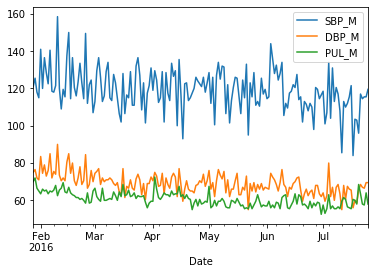

In [16]:
test_all[test_all['Name'].isin(['N/Predict 0097'])][260:260+180].plot(x = 'Date', y = ['SBP_M', 'DBP_M', 'PUL_M'])

In [24]:
day_param = 180
#df_bp_gr = test_all.groupby(by = ['Name','Date'], as_index = False, observed = True).mean()
df_bp_gr = test_all.set_index('Date')
#df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
#df_bp_gr = df_bp_gr.reset_index(drop = True)

In [25]:
df_bp_gr = df_bp_gr.groupby(['Name'], as_index=False).resample(str(day_param)+'D', label='left').apply(list)
#df_bp_gr = df_bp_gr.reset_index(drop = True)

In [26]:
df_bp_gr

DBP_E  \
    Date                                                            
0   2015-01-28  [76.5, 86.5, 73.0, 77.0, 77.5, 68.5, 79.0, 71....   
    2015-07-27  [73.5, 71.5, 66.0, 78.5, 73.5, 73.5, 75.0, 75....   
    2016-01-23  [73.5, 71.0, 75.5, 73.0, 82.5, 75.0, 75.0, 71....   
    2016-07-21  [83.5, 83.5, 81.5, 82.5, 80.5, 81.5, 79.5, 80....   
    2017-01-17  [74.0, 73.0, 72.5, 77.0, 78.0, 86.0, 74.0, 78....   
1   2015-02-06  [72.0, 74.5, 77.5, 82.0, 71.5, 79.5, 68.5, 78....   
    2015-08-05  [71.5, 68.0, 69.5, 74.5, 75.0, 71.0, 68.0, 67....   
    2016-02-01  [74.0, 69.0, 68.0, 67.5, 73.0, 62.0, 68.5, 67....   
    2016-07-30  [65.5, 72.0, 73.0, 69.0, 65.5, 69.0, 71.0, 66....   
    2017-01-26  [69.0, 58.5, 58.0, 57.5, 63.5, 56.5, 63.5, 57....   
    2017-07-25  [65.5, 61.0, 61.0, 66.0, 77.0, 63.5, 60.0, 58....   
    2018-01-21  [62.5, 75.5, 62.0, 67.5, 65.0, 67.5, 59.0, 62....   
2   2015-02-12  [68.0, 77.0, 81.5, 53.0, 76.0, 68.0, 65.5, 65....   
    2015-08-11  [49.0, 43.5, 63.5, 47.5, 49.0, 57.0, 75.0, 69....   
    2016-02-07  [82.0, 75.5, 43.5, 76.0, 67.5, 80.5, 82.5, 73....   
    2016-08-05  [68.5, 68.5, 59.0, 71.5, 82.0, 57.0, 75.0, 65....   
    2017-02-01  [62.5, 63.0, 58.5, 58.5, 69.0, 73.0, 65.0, 65....   
    2017-07-31  [57.0, 57.0, 57.0, 65.5, 63.5, 63.5, 57.5, 57....   
    2018-01-27  [67.5, 57.0, 54.5, 57.0, 61.5, 63.0, 60.0, 63....   
3   2015-02-11  [75.0, 68.5, 74.5, 70.0, 63.0, 73.0, 70.5, 70....   
    2015-08-10  [74.0, 78.0, 92.5, 85.0, 87.0, 79.0, 82.5, 72....   
    2016-02-06  [64.0, 80.0, 75.0, 66.5, 68.5, 71.0, 65.0, 69....   
    2016-08-04  [60.5, 68.0, 63.0, 65.0, 67.0, 68.0, 66.0, 68....   
4   2015-02-18  [81.5, 79.5, 78.5, 78.5, 78.5, 69.5, 73.5, 74....   
    2015-08-17  [67.5, 69.5, 63.0, 67.0, 68.0, 52.0, 71.0, 74....   
    2016-02-13  [56.0, 54.5, 60.0, 68.0, 57.5, 71.0, 58.5, 59....   
    2016-08-11  [71.0, 66.5, 70.5, 64.0, 72.5, 71.5, 65.0, 64....   
    2017-02-07  [57.0, 64.5, 61.0, 57.5, 52.5, 56.5, 58.5, 55....   
    2017-08-06  [67.5, 67.5, 66.5, 70.0, 66.0, 70.5, 70.0, 73....   
    2018-02-02  [53.0, 61.5, 61.5, 61.5, 68.0, 58.5, 49.5, 65....   
...                                                           ...   
403 2018-01-17  [68.0, 68.0, 68.0, 68.0, 68.0, 67.5, 67.5, 67....   
404 2017-07-28  [82.0, 66.5, 71.5, 75.0, 73.5, 67.0, 68.0, 66....   
    2018-01-24  [71.0, 64.0, 72.0, 62.0, 68.5, 75.0, 64.5, 72....   
405 2017-08-05  [70.5, 69.0, 76.5, 65.5, 76.5, 72.0, 71.5, 71....   
    2018-02-01  [66.5, 69.5, 69.5, 68.0, 65.0, 69.5, 68.5, 68....   
406 2017-08-30  [85.0, 85.5, 87.0, 83.5, 86.5, 81.0, 83.5, 82....   
    2018-02-26  [78.5, 78.5, 76.5, 78.5, 78.5, 88.5, 78.5, 79....   
407 2017-09-15  [71.0, 76.0, 79.0, 68.0, 72.0, 73.0, 70.5, 73....   
    2018-03-14  [59.0, 63.0, 62.0, 70.5, 59.5, 65.5, 67.5, 71....   
408 2017-09-27  [65.5, 70.0, 60.0, 64.0, 72.0, 64.0, 64.0, 68....   
    2018-03-26  [59.0, 61.0, 69.5, 62.0, 79.0, 63.0, 66.5, 57....   
409 2017-10-01  [73.5, 69.5, 69.5, 72.0, 72.0, 72.0, 72.0, 66....   
    2018-03-30  [70.0, 66.0, 65.0, 63.5, 63.5, 63.5, 64.0, 64....   
410 2017-10-13  [75.5, 85.5, 84.5, 80.5, 87.0, 75.0, 79.0, 84....   
    2018-04-11  [79.0, 84.0, 81.5, 84.5, 77.5, 71.5, 74.0, 74....   
411 2017-12-16  [101.0, 98.5, 96.5, 88.5, 101.0, 101.0, 97.5, ...   
412 2017-10-01  [90.5, 81.0, 76.0, 91.0, 91.0, 82.5, 71.5, 77....   
    2018-03-30  [94.0, 85.0, 97.5, 81.0, 92.0, 84.0, 88.5, 87....   
413 2018-01-04  [77.0, 77.0, 77.0, 77.0, 87.5, 87.5, 79.5, 79....   
414 2018-01-19  [114.0, 114.0, 100.0, 114.5, 109.5, 96.5, 116....   
415 2018-02-01  [84.5, 80.0, 88.0, 93.0, 91.0, 94.0, 89.0, 90....   
416 2017-12-22  [49.0, 49.0, 49.0, 49.0, 52.0, 55.5, 53.5, 59....   
417 2018-01-06  [83.0, 83.0, 83.0, 78.5, 78.5, 78.5, 78.5, 78....   
418 2017-12-06  [73.0, 74.5, 70.0, 72.5, 78.0, 65.5, 80.0, 68....   
419 2017-10-22  [65.0, 62.5, 63.0, 64.5, 63.0, 62.0, 66.0, 65....   
    2018-04-20                     [60.5, 60.0, 70.5, 64.5

In [28]:
target_df = []
for col_name in df_bp_gr.columns:
    target_df.append(
        pd.DataFrame(
            [ row for row in df_bp_gr[col_name][:]],
            columns = [col_name + str(i+1) for i in range(day_param)]
        )
    )
target_df = pd.concat(target_df, axis = 1)

In [29]:
target_df['Name'] = target_df['Name1']
target_df.drop(
    labels = target_df.loc[:,'Name1':'Name180'].columns.tolist(), 
    axis = 1, 
    inplace = True
)
target_df.dropna(inplace = True)

In [30]:
target_df

,DBP_E1,DBP_E2,DBP_E3,DBP_E4,DBP_E5,DBP_E6,DBP_E7,DBP_E8,DBP_E9,DBP_E10,...,SBP_M172,SBP_M173,SBP_M174,SBP_M175,SBP_M176,SBP_M177,SBP_M178,SBP_M179,SBP_M180,Name
0,76.5,86.5,73.0,77.0,77.5,68.5,79.0,71.5,80.0,74.0,...,124.5,138.0,126.5,132.5,137.5,131.0,126.5,134.5,141.5,N/Predict 0001
1,73.5,71.5,66.0,78.5,73.5,73.5,75.0,75.0,75.0,75.0,...,134.0,133.5,134.0,143.5,131.5,132.5,134.5,128.5,147.5,N/Predict 0001
2,73.5,71.0,75.5,73.0,82.5,75.0,75.0,71.5,74.5,82.5,...,147.0,151.0,163.5,149.5,159.0,152.0,155.5,162.0,153.5,N/Predict 0001
3,83.5,83.5,81.5,82.5,80.5,81.5,79.5,80.0,75.5,77.0,...,143.0,127.5,134.0,134.0,131.0,139.0,143.0,151.0,147.5,N/Predict 0001
5,72.0,74.5,77.5,82.0,71.5,79.5,68.5,78.5,81.5,81.0,...,157.0,148.5,145.0,143.0,155.0,149.5,146.5,154.5,151.5,N/Predict 0002
6,71.5,68.0,69.5,74.5,75.0,71.0,68.0,67.0,69.5,71.5,...,169.0,178.0,165.5,172.0,159.0,158.5,147.0,150.0,147.5,N/Predict 0002
7,74.0,69.0,68.0,67.5,73.0,62.0,68.5,67.0,61.5,64.0,...,156.0,163.0,163.0,156.5,149.0,158.5,155.0,152.0,159.0,N/Predict 0002
8,65.5,72.0,73.0,69.0,65.5,69.0,71.0,66.5,65.0,74.5,...,138.0,130.5,145.5,140.0,117.0,139.0,125.0,122.5,122.0,N/Predict 0002
9,69.0,58.5,58.0,57.5,63.5,56.5,63.5,57.0,61.0,60.5,...,131.0,138.0,134.5,145.0,138.0,126.5,133.0,138.5,128.5,N/Predict 0002
10,65.5,61.0,61.0,66.0,77.0,63.5,60.0,58.0,57.0,60.5,...,140.0,139.0,111.5,130.5,116.0,119.0,97.0,115.5,120.5,N/Predict 0002


## Determine labels

In [31]:
target_df['msbp'] = target_df.loc[:, 'SBP_M1':'SBP_M84'].mean(axis = 1)
target_df['mdbp'] = target_df.loc[:, 'DBP_M1':'DBP_M84'].mean(axis = 1)
target_df.reset_index(inplace = True, drop = True)

In [49]:
target_df['labels'] = 0
s_hyflag = target_df['msbp'] >= 135
target_df.loc[s_hyflag == True, 'labels'] = int(1)

d_hyflag = target_df['mdbp'] >= 85
target_df.loc[d_hyflag == True, 'labels'] = int(2)

sd_hyflag = np.logical_and( target_df['msbp'] >= 135, target_df['mdbp'] >= 85)
target_df.loc[sd_hyflag == True, 'labels'] = int(3)

s_hyflag = target_df['msbp'] >= 150
target_df.loc[s_hyflag == True, 'labels'] = int(4)

In [50]:
target_df_arr = target_df.iloc[:, :-4].values.reshape(
    len(target_df), 
    len(target_df.iloc[:, :-4].columns) // day_param, 
    day_param
).transpose(0,2,1)

In [51]:
target_df_arr.shape

(1387, 180, 6)

## Wirte Data

In [52]:
np.savez('/home/hiroshi_koshimizu/work/RCGAN/inputs/bp_data_180.npz',x = target_df_arr, y = target_df['labels'].values)

In [53]:
target_df['labels'].value_counts()

0    914
1    161
2    147
3    130
4     35
Name: labels, dtype: int64

In [54]:
target_df_arr

array([[[ 76.5,  85. ,  71.5,  69. , 130. , 155.5],
        [ 86.5,  90.5,  71. ,  74. , 154. , 159. ],
        [ 73. ,  75. ,  65.5,  67. , 123. , 122. ],
        ...,
        [ 69. ,  75.5,  66.5,  70.5, 116.5, 126.5],
        [ 69. ,  71.5,  66.5,  69.5, 116.5, 134.5],
        [ 73.5,  77.5,  64. ,  70.5, 136. , 141.5]],

       [[ 73.5,  73. ,  66. ,  67.5, 127.5, 134.5],
        [ 71.5,  74. ,  65. ,  61.5, 130. , 136.5],
        [ 66. ,  78. ,  68.5,  68.5, 122. , 140. ],
        ...,
        [ 84. ,  73. ,  65. ,  69. , 154. , 134.5],
        [ 74. ,  75. ,  68.5,  69. , 141. , 128.5],
        [ 80.5,  78. ,  60. ,  64.5, 158. , 147.5]],

       [[ 73.5,  78. ,  68.5,  65. , 132. , 145.5],
        [ 71. ,  77. ,  68.5,  64.5, 120. , 132. ],
        [ 75.5,  76. ,  73. ,  66. , 132. , 144. ],
        ...,
        [ 87.5,  92. ,  70. ,  72. , 166.5, 155.5],
        [ 74. ,  86.5,  67.5,  62.5, 146. , 162. ],
        [ 77. ,  88. ,  67.5,  72. , 156. , 153.5]],

       ...,

      